# **1. LIBRARIES**

In [1]:
!pip install keras_unet_collection

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.5 MB/s eta 0:00:00


In [2]:
import os
import pickle
import random
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import keras
import time
from tqdm import tqdm
from keras.optimizers import Adam
from keras_unet_collection import models
from keras.callbacks import EarlyStopping

# **2. TRAINING**

In [3]:
img_size = 128

In [4]:
train_cxr = np.load('/kaggle/input/lung-segmentation-dataset-ch0/without_convexhull/train/cxr.npy')
train_mask = np.load('/kaggle/input/lung-segmentation-dataset-ch0/without_convexhull/train/mask.npy')
val_cxr = np.load('/kaggle/input/lung-segmentation-dataset-ch0/without_convexhull/val/cxr.npy')
val_mask = np.load('/kaggle/input/lung-segmentation-dataset-ch0/without_convexhull/val/mask.npy')

print(np.shape(train_cxr))
print(np.shape(train_mask))
print(np.shape(val_cxr))
print(np.shape(val_mask))

(16927, 128, 128)
(16927, 128, 128)
(2119, 128, 128)
(2119, 128, 128)


In [5]:
random.seed(42)

idx_list = np.arange(np.shape(train_cxr)[0])
random.shuffle(idx_list)

train_cxr_shuffle = np.zeros(np.shape(train_cxr))
train_mask_shuffle = np.zeros(np.shape(train_mask))
for i in idx_list:
    train_cxr_shuffle[i] = train_cxr[i]
    train_mask_shuffle[i] = train_mask[i]

del train_cxr
del train_mask

x_train = train_cxr_shuffle.reshape(-1, img_size, img_size, 1) / 255.0
y_train = (train_mask_shuffle.reshape(-1, img_size, img_size, 1) / 255.0 >= 0.5).astype(np.float32)

del train_cxr_shuffle
del train_mask_shuffle

print(np.shape(x_train))
print(np.shape(y_train))

random.seed(42)

idx_list = np.arange(np.shape(val_cxr)[0])
random.shuffle(idx_list)

val_cxr_shuffle = np.zeros(np.shape(val_cxr))
val_mask_shuffle = np.zeros(np.shape(val_mask))
for i in idx_list:
    val_cxr_shuffle[i] = val_cxr[i]
    val_mask_shuffle[i] = val_mask[i]

del val_cxr
del val_mask

x_val = val_cxr_shuffle.reshape(-1, img_size, img_size, 1) / 255.0
y_val = (val_mask_shuffle.reshape(-1, img_size, img_size, 1) / 255.0 >= 0.5).astype(np.float32)

del val_cxr_shuffle
del val_mask_shuffle

print(np.shape(x_val))
print(np.shape(y_val))

(16927, 128, 128, 1)
(16927, 128, 128, 1)
(2119, 128, 128, 1)
(2119, 128, 128, 1)


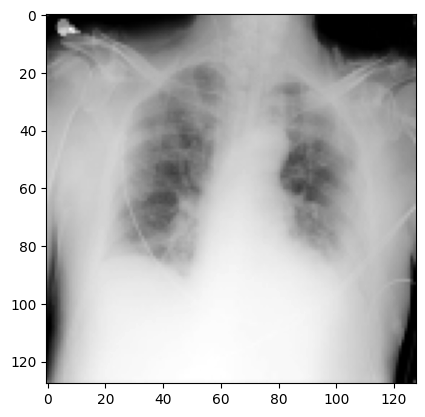

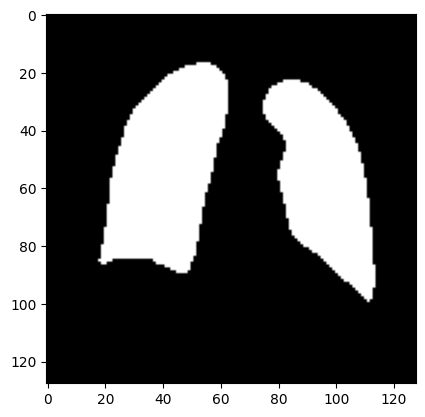

In [6]:
plt.imshow(x_train[0], cmap='gray')
plt.show()
plt.imshow(y_train[0], cmap='gray')
plt.show()

In [7]:
threshold = 0.5

def dice_coef(y_true, y_pred, smooth=1):
    y_pred_bin = K.cast((y_pred >= threshold), tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred_bin), axis=[1])
    combination = K.sum(y_true, [1]) + K.sum(y_pred_bin, [1])
    dice = K.mean((intersection + intersection + smooth) / (combination + smooth), axis=0)
    return dice

def iou_coef(y_true, y_pred, smooth=1):
    y_pred_bin = K.cast((y_pred >= threshold), tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred_bin), axis=[1])
    union = K.sum(y_true, [1]) + K.sum(y_pred_bin, [1]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [8]:
r2unet = models.r2_unet_2d(
    input_size=(img_size, img_size, 1), 
    filter_num=[16, 32, 64, 128, 256], 
    n_labels=1,
    stack_num_down=2,
    stack_num_up=2,
    activation='ReLU',
    recur_num=2,
    output_activation='Sigmoid', 
    pool='max'
)

r2unet.compile(optimizer=Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=[dice_coef, iou_coef])

r2unet.summary()

Model: "r2_unet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ r2_unet_input             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv        │ (None, 128, 128, 16)   │             32 │ r2_unet_input[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv0       │ (None, 128, 128, 16)   │          2,320 │ r2_unet_down0_conv[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_activation0 │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_conv0[0… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_add0_0      │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_activat… │
│ (Add)                     │                        │                │ r2_unet_down0_conv[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv0_0     │ (None, 128, 128, 16)   │          2,320 │ r2_unet_down0_add0_0[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_activation… │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_conv0_0… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_add0_1      │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_activat… │
│ (Add)                     │                        │                │ r2_unet_down0_conv[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv0_1     │ (None, 128, 128, 16)   │          2,320 │ r2_unet_down0_add0_1[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_activation… │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_conv0_1… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv1       │ (None, 128, 128, 16)   │          2,320 │ r2_unet_down0_activat… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_activation1 │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_conv1[0… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_add1_0      │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_activat… │
│ (Add)                     │                        │                │ r2_unet_down0_activat… │
├──────────────────────

 Total params: 6,373,169 (24.31 MB)

 Trainable params: 6,373,169 (24.31 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history_train_dice = []
history_train_iou = []
history_train_loss = []
history_val_dice = []
history_val_iou = []
history_val_loss = []

def custom_fit(model, x_train, y_train, x_val, y_val, epochs, batch_size):
    excution_time = 0
    num_train_samples = np.shape(x_train)[0]
    num_val_samples = np.shape(x_val)[0]

    for epoch in range(epochs):
        print('\033[1mEpoch {}/{}\033[0m'.format(epoch + 1, epochs))

        train_dice, train_iou, train_loss = 0.0, 0.0, 0.0
        start_time = time.time()
        for i in tqdm(range(0, num_train_samples, batch_size)):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            metrics = model.fit(x=x_batch, y=y_batch, batch_size=batch_size, epochs=1, verbose=False).history
            dice = metrics.get('dice_coef')[0]
            iou = metrics.get('iou_coef')[0]
            loss = metrics.get('loss')[0]
            
            train_dice += dice * np.shape(x_batch)[0]
            train_iou += iou * np.shape(x_batch)[0]
            train_loss += loss * np.shape(x_batch)[0]
        end_time = time.time()

        train_dice /= num_train_samples
        train_iou /= num_train_samples
        train_loss /= num_train_samples
        print('   train_dice_coef: {} - train_iou_coef: {} - train_loss: {}'.format(round(train_dice, 4), round(train_iou, 4), round(train_loss, 4)))
        history_train_dice.append(train_dice)
        history_train_iou.append(train_iou)
        history_train_loss.append(train_loss)
        
        metrics = model.evaluate(x_val, y_val, batch_size=batch_size, return_dict=True, verbose=False)
        val_dice = metrics['dice_coef']
        val_iou = metrics['iou_coef']
        val_loss = metrics['loss']

        print('   val_dice_coef: {} - val_iou_coef: {} - val_loss: {}'.format(round(val_dice, 4), round(val_iou, 4), round(val_loss, 4)))
        history_val_dice.append(val_dice)
        history_val_iou.append(val_iou)
        history_val_loss.append(val_loss)

        excution_time_epoch = int(end_time - start_time)
        excution_time += excution_time_epoch
        print('   time: {}s\n'.format(excution_time_epoch))

    print('Training excution time: {}s\n'.format(excution_time))

In [10]:
custom_fit(r2unet, x_train, y_train, x_val, y_val, epochs=50, batch_size=128)

del x_train
del y_train
del x_val
del y_val

Epoch 1/50


100%|██████████| 133/133 [01:51<00:00,  1.20it/s]


   train_dice_coef: 0.6872 - train_iou_coef: 0.6522 - train_loss: 0.2731
   val_dice_coef: 0.8666 - val_iou_coef: 0.8302 - val_loss: 0.1341
   time: 111s

Epoch 2/50


100%|██████████| 133/133 [01:00<00:00,  2.20it/s]


   train_dice_coef: 0.8875 - train_iou_coef: 0.853 - train_loss: 0.1061
   val_dice_coef: 0.9043 - val_iou_coef: 0.8725 - val_loss: 0.0977
   time: 60s

Epoch 3/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9223 - train_iou_coef: 0.8929 - train_loss: 0.0721
   val_dice_coef: 0.9231 - val_iou_coef: 0.8941 - val_loss: 0.0785
   time: 60s

Epoch 4/50


100%|██████████| 133/133 [01:00<00:00,  2.22it/s]


   train_dice_coef: 0.9342 - train_iou_coef: 0.9079 - train_loss: 0.0595
   val_dice_coef: 0.9369 - val_iou_coef: 0.9112 - val_loss: 0.0638
   time: 60s

Epoch 5/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.943 - train_iou_coef: 0.9194 - train_loss: 0.0503
   val_dice_coef: 0.9448 - val_iou_coef: 0.9214 - val_loss: 0.0556
   time: 60s

Epoch 6/50


100%|██████████| 133/133 [01:00<00:00,  2.20it/s]


   train_dice_coef: 0.9494 - train_iou_coef: 0.9277 - train_loss: 0.0437
   val_dice_coef: 0.9494 - val_iou_coef: 0.9276 - val_loss: 0.051
   time: 60s

Epoch 7/50


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


   train_dice_coef: 0.9537 - train_iou_coef: 0.9336 - train_loss: 0.0392
   val_dice_coef: 0.9535 - val_iou_coef: 0.9331 - val_loss: 0.0463
   time: 59s

Epoch 8/50


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


   train_dice_coef: 0.957 - train_iou_coef: 0.9381 - train_loss: 0.0356
   val_dice_coef: 0.9566 - val_iou_coef: 0.9373 - val_loss: 0.0427
   time: 59s

Epoch 9/50


100%|██████████| 133/133 [01:01<00:00,  2.16it/s]


   train_dice_coef: 0.9595 - train_iou_coef: 0.9416 - train_loss: 0.033
   val_dice_coef: 0.9588 - val_iou_coef: 0.9404 - val_loss: 0.0402
   time: 61s

Epoch 10/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9617 - train_iou_coef: 0.9445 - train_loss: 0.0307
   val_dice_coef: 0.961 - val_iou_coef: 0.9435 - val_loss: 0.0375
   time: 60s

Epoch 11/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9632 - train_iou_coef: 0.9468 - train_loss: 0.0292
   val_dice_coef: 0.9627 - val_iou_coef: 0.9459 - val_loss: 0.0353
   time: 60s

Epoch 12/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9649 - train_iou_coef: 0.9491 - train_loss: 0.0275
   val_dice_coef: 0.964 - val_iou_coef: 0.9477 - val_loss: 0.0339
   time: 60s

Epoch 13/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9664 - train_iou_coef: 0.9512 - train_loss: 0.0259
   val_dice_coef: 0.9652 - val_iou_coef: 0.9494 - val_loss: 0.0328
   time: 60s

Epoch 14/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9678 - train_iou_coef: 0.953 - train_loss: 0.0247
   val_dice_coef: 0.9665 - val_iou_coef: 0.9511 - val_loss: 0.0312
   time: 60s

Epoch 15/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9692 - train_iou_coef: 0.9551 - train_loss: 0.0232
   val_dice_coef: 0.9674 - val_iou_coef: 0.9525 - val_loss: 0.0301
   time: 60s

Epoch 16/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9702 - train_iou_coef: 0.9563 - train_loss: 0.0224
   val_dice_coef: 0.9685 - val_iou_coef: 0.954 - val_loss: 0.0292
   time: 60s

Epoch 17/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9708 - train_iou_coef: 0.9572 - train_loss: 0.0218
   val_dice_coef: 0.9692 - val_iou_coef: 0.9549 - val_loss: 0.029
   time: 60s

Epoch 18/50


100%|██████████| 133/133 [01:00<00:00,  2.20it/s]


   train_dice_coef: 0.9714 - train_iou_coef: 0.958 - train_loss: 0.0212
   val_dice_coef: 0.9695 - val_iou_coef: 0.9554 - val_loss: 0.0291
   time: 60s

Epoch 19/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9713 - train_iou_coef: 0.958 - train_loss: 0.0212
   val_dice_coef: 0.9698 - val_iou_coef: 0.9559 - val_loss: 0.0289
   time: 60s

Epoch 20/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9719 - train_iou_coef: 0.9588 - train_loss: 0.0208
   val_dice_coef: 0.9696 - val_iou_coef: 0.9556 - val_loss: 0.0305
   time: 60s

Epoch 21/50


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


   train_dice_coef: 0.9726 - train_iou_coef: 0.9598 - train_loss: 0.0202
   val_dice_coef: 0.9707 - val_iou_coef: 0.9571 - val_loss: 0.0283
   time: 59s

Epoch 22/50


100%|██████████| 133/133 [01:00<00:00,  2.22it/s]


   train_dice_coef: 0.9735 - train_iou_coef: 0.961 - train_loss: 0.0194
   val_dice_coef: 0.9705 - val_iou_coef: 0.9568 - val_loss: 0.0309
   time: 60s

Epoch 23/50


100%|██████████| 133/133 [01:00<00:00,  2.22it/s]


   train_dice_coef: 0.9739 - train_iou_coef: 0.9616 - train_loss: 0.019
   val_dice_coef: 0.9708 - val_iou_coef: 0.9572 - val_loss: 0.0299
   time: 60s

Epoch 24/50


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


   train_dice_coef: 0.9746 - train_iou_coef: 0.9625 - train_loss: 0.0184
   val_dice_coef: 0.9723 - val_iou_coef: 0.9593 - val_loss: 0.0274
   time: 59s

Epoch 25/50


100%|██████████| 133/133 [01:00<00:00,  2.22it/s]


   train_dice_coef: 0.9748 - train_iou_coef: 0.9629 - train_loss: 0.0182
   val_dice_coef: 0.9726 - val_iou_coef: 0.9599 - val_loss: 0.027
   time: 60s

Epoch 26/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9748 - train_iou_coef: 0.9629 - train_loss: 0.0181
   val_dice_coef: 0.9723 - val_iou_coef: 0.9593 - val_loss: 0.0288
   time: 60s

Epoch 27/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9752 - train_iou_coef: 0.9634 - train_loss: 0.0179
   val_dice_coef: 0.9725 - val_iou_coef: 0.9598 - val_loss: 0.0282
   time: 60s

Epoch 28/50


100%|██████████| 133/133 [01:00<00:00,  2.19it/s]


   train_dice_coef: 0.9759 - train_iou_coef: 0.9643 - train_loss: 0.0174
   val_dice_coef: 0.9729 - val_iou_coef: 0.9602 - val_loss: 0.0283
   time: 60s

Epoch 29/50


100%|██████████| 133/133 [01:00<00:00,  2.20it/s]


   train_dice_coef: 0.9764 - train_iou_coef: 0.965 - train_loss: 0.017
   val_dice_coef: 0.9732 - val_iou_coef: 0.9607 - val_loss: 0.028
   time: 60s

Epoch 30/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.977 - train_iou_coef: 0.9658 - train_loss: 0.0165
   val_dice_coef: 0.973 - val_iou_coef: 0.9606 - val_loss: 0.0289
   time: 60s

Epoch 31/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9768 - train_iou_coef: 0.9656 - train_loss: 0.0166
   val_dice_coef: 0.9722 - val_iou_coef: 0.9595 - val_loss: 0.0312
   time: 60s

Epoch 32/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9771 - train_iou_coef: 0.966 - train_loss: 0.0164
   val_dice_coef: 0.9732 - val_iou_coef: 0.9609 - val_loss: 0.0281
   time: 60s

Epoch 33/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9774 - train_iou_coef: 0.9664 - train_loss: 0.0161
   val_dice_coef: 0.9734 - val_iou_coef: 0.9612 - val_loss: 0.0277
   time: 60s

Epoch 34/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9772 - train_iou_coef: 0.9662 - train_loss: 0.0162
   val_dice_coef: 0.9738 - val_iou_coef: 0.9617 - val_loss: 0.0271
   time: 60s

Epoch 35/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9768 - train_iou_coef: 0.9657 - train_loss: 0.0165
   val_dice_coef: 0.9738 - val_iou_coef: 0.9616 - val_loss: 0.0273
   time: 60s

Epoch 36/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9774 - train_iou_coef: 0.9665 - train_loss: 0.0161
   val_dice_coef: 0.9745 - val_iou_coef: 0.9627 - val_loss: 0.0257
   time: 60s

Epoch 37/50


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


   train_dice_coef: 0.9778 - train_iou_coef: 0.967 - train_loss: 0.0157
   val_dice_coef: 0.975 - val_iou_coef: 0.9634 - val_loss: 0.0245
   time: 59s

Epoch 38/50


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


   train_dice_coef: 0.9787 - train_iou_coef: 0.9683 - train_loss: 0.015
   val_dice_coef: 0.9753 - val_iou_coef: 0.9638 - val_loss: 0.0255
   time: 59s

Epoch 39/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9789 - train_iou_coef: 0.9685 - train_loss: 0.0151
   val_dice_coef: 0.9752 - val_iou_coef: 0.9636 - val_loss: 0.0267
   time: 60s

Epoch 40/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9788 - train_iou_coef: 0.9684 - train_loss: 0.0151
   val_dice_coef: 0.9757 - val_iou_coef: 0.9642 - val_loss: 0.0255
   time: 60s

Epoch 41/50


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


   train_dice_coef: 0.9787 - train_iou_coef: 0.9683 - train_loss: 0.0151
   val_dice_coef: 0.9754 - val_iou_coef: 0.9639 - val_loss: 0.0253
   time: 59s

Epoch 42/50


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


   train_dice_coef: 0.9793 - train_iou_coef: 0.9691 - train_loss: 0.0146
   val_dice_coef: 0.9762 - val_iou_coef: 0.965 - val_loss: 0.0242
   time: 59s

Epoch 43/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9801 - train_iou_coef: 0.9701 - train_loss: 0.014
   val_dice_coef: 0.9758 - val_iou_coef: 0.9644 - val_loss: 0.0264
   time: 60s

Epoch 44/50


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


   train_dice_coef: 0.9809 - train_iou_coef: 0.9713 - train_loss: 0.0134
   val_dice_coef: 0.9762 - val_iou_coef: 0.9649 - val_loss: 0.0262
   time: 59s

Epoch 45/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9812 - train_iou_coef: 0.9717 - train_loss: 0.0131
   val_dice_coef: 0.9763 - val_iou_coef: 0.9652 - val_loss: 0.0261
   time: 60s

Epoch 46/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9812 - train_iou_coef: 0.9718 - train_loss: 0.0131
   val_dice_coef: 0.9764 - val_iou_coef: 0.9653 - val_loss: 0.0254
   time: 60s

Epoch 47/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.9809 - train_iou_coef: 0.9713 - train_loss: 0.0134
   val_dice_coef: 0.9765 - val_iou_coef: 0.9654 - val_loss: 0.0258
   time: 60s

Epoch 48/50


100%|██████████| 133/133 [01:00<00:00,  2.19it/s]


   train_dice_coef: 0.9804 - train_iou_coef: 0.9706 - train_loss: 0.0137
   val_dice_coef: 0.9759 - val_iou_coef: 0.9649 - val_loss: 0.0257
   time: 60s

Epoch 49/50


100%|██████████| 133/133 [01:00<00:00,  2.20it/s]


   train_dice_coef: 0.9806 - train_iou_coef: 0.9709 - train_loss: 0.0137
   val_dice_coef: 0.9767 - val_iou_coef: 0.9657 - val_loss: 0.0239
   time: 60s

Epoch 50/50


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


   train_dice_coef: 0.981 - train_iou_coef: 0.9716 - train_loss: 0.0134
   val_dice_coef: 0.9767 - val_iou_coef: 0.9658 - val_loss: 0.0249
   time: 60s

Training excution time: 3043s



In [11]:
os.makedirs('/kaggle/working/without_convexhull/model', exist_ok=True)

r2unet.save('/kaggle/working/without_convexhull/model/R2U-Net.h5')

os.makedirs('/kaggle/working/without_convexhull/history', exist_ok=True)

with open('/kaggle/working/without_convexhull/history/train_dice.pkl', 'wb') as f:
    pickle.dump(np.array(history_train_dice), f)
with open('/kaggle/working/without_convexhull/history/train_iou.pkl', 'wb') as f:
    pickle.dump(np.array(history_train_iou), f)
with open('/kaggle/working/without_convexhull/history/train_loss.pkl', 'wb') as f:
    pickle.dump(np.array(history_train_loss), f)
with open('/kaggle/working/without_convexhull/history/val_dice.pkl', 'wb') as f:
    pickle.dump(np.array(history_val_dice), f)
with open('/kaggle/working/without_convexhull/history/val_iou.pkl', 'wb') as f:
    pickle.dump(np.array(history_val_iou), f)
with open('/kaggle/working/without_convexhull/history/val_loss.pkl', 'wb') as f:
    pickle.dump(np.array(history_val_loss), f)